In [79]:
import yfinance as yf  # for data
import pandas_datareader.data as web
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
from pandas_datareader._utils import RemoteDataError
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
plt.rcParams['figure.figsize'] = [10, 6]
import warnings
warnings.filterwarnings('ignore')


### Getting data

Daiy data can be easily imported using `pandas_datareader`. For shorter intervals I will be using `yfinance`

In [80]:
# How yfinance can be used ""

data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "SPY",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "7d",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1m",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = False,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Datetime,,,,,
2020-10-15 09:30:00-04:00,343.540009,343.540009,343.519989,343.519989,3050737
2020-10-15 09:31:00-04:00,343.529999,344.049988,343.519989,343.910004,520274
2020-10-15 09:32:00-04:00,343.910004,344.299988,343.750000,344.279999,364070
2020-10-15 09:33:00-04:00,344.279999,344.410004,344.184998,344.269989,365402
2020-10-15 09:34:00-04:00,344.274994,344.274994,344.113007,344.260010,232173
...,...,...,...,...,...
2020-10-23 14:30:00-04:00,345.029999,345.059998,344.989990,345.019989,74249
2020-10-23 14:31:00-04:00,345.029999,345.049988,345.000000,345.010010,53200
2020-10-23 14:32:00-04:00,345.000000,345.160004,345.000000,345.079987,119907


In [81]:
data = yf.download(tickers = "SPY",period = "7d",interval = "1d",group_by = 'ticker',auto_adjust = True,prepost = False,threads = True,proxy = None)



[*********************100%***********************]  1 of 1 completed


In [82]:
data = data.reset_index()
data

,Date,Open,High,Low,Close,Volume
0,2020-10-15,343.709991,348.019989,343.130005,347.500000,60357700
1,2020-10-16,348.959991,350.750000,347.100006,347.290009,89501900
2,2020-10-19,348.649994,349.329987,341.040009,342.010010,68425600
3,2020-10-20,343.459991,346.880005,342.640015,343.380005,60051900
4,2020-10-21,343.329987,345.670013,342.399994,342.730011,63575000
5,2020-10-22,342.959991,345.239990,340.649994,344.609985,55232400
6,2020-10-23,345.929993,345.989990,343.130005,345.049988,28641147


### Stratgeies

- Stratgey 1:Volume tarading, look for the past data, get stocks where volumes of today and yesterday are both postive and prior to that there were two days with negative volume.

- Stratgey 2:Macd trading, look for the past data where have certain pattern for macd, we are looking for intersections that indicates upper tredn

- Strategy 3: Ballinger trading, look for the past data where we have the price dipping below the lower ballinger band, for buying opportunity 
---

- Our investigation space will be the list of stocks in series_tickers file

In [83]:
#Download file "series_tickers.p" from github or create your own list of tickers
series_tickers = pickle.load(open("series_tickers.p", "rb" ))

In [84]:
df = pd.DataFrame(series_tickers).reset_index()
df

,Symbol,Security Name
0,VG,Vonage Holdings Corp. - Common Stock
1,CDNS,"Cadence Design Systems, Inc. - Common Stock"
2,UONE,"Urban One, Inc. - Class A Common Stock"
3,AVGO,Broadcom Inc. - Common Stock
4,ADBE,Adobe Inc. - Common Stock
...,...,...
299,CAR,"Avis Budget Group, Inc. - Common Stock"
300,TNXP,Tonix Pharmaceuticals Holding Corp. - Common S...
301,ZS,"Zscaler, Inc. - Common Stock"
302,MGI,"Moneygram International, Inc. - Common Stock"


In [85]:
#(df.index == 'JKS').any()
list_of_lists = [['AAPL','AAPL'],['IBM','IBM'],['AMD','AMD'],['T','T'],['DAL','DAL'],['J&J','J&J'],['INTC','INTC'],['GE','GE'],['NIO','NIO'],['JKS','JKS']]
df_new = pd.DataFrame(list_of_lists, columns = ['Symbol','Security Name'])

# new tickers
series_tickers = pd.concat([df,df_new],axis = 0).set_index('Symbol').iloc[:,0]

-  here will create a class for the stock

In [86]:
class stock:
    def __init__(self,stock = 'NIO',price = 'Close'):
        self.stock = stock
        self.price = price
    
    def get_df(self):
        
        '''
        volume trading create a data frame for the stocks and manipulate it, a new column reflecting postive or negative is created, green for postive
        and red for negative
        
        inputs: 
        ------
        None
        
        returns:
        ------ 
        df : a dataframe which will be used with the subsequent  functions
        '''
        price = self.price
        df = yf.download(tickers = self.stock,period = "7d",interval = "5m",group_by = 'ticker',auto_adjust = True,prepost = False,threads = True,proxy = None)
        df['close_before'] = df[price].shift(1) 
        df['relative_price'] = df[price] - df['close_before']
        df["Color"] = np.where(df["relative_price"]<0, 'red', 'green')

        df = df.iloc[::-1]
        df = df.reset_index()
        df = df.fillna(0)
        self.df = df
        return self.df 
    
    def macd(self):
        
        '''
        macd trading, create a data frame for the stocks and manipulate it, a new column reflecting postive or negative is created, green for when macd is above the signal line
        and red for when when the macd is below singal line
        
        inputs: 
        ------
        None
        
        returns:
        ------ 
        df : a dataframe which will be used with the subsequent  functions
        '''

        
        df = self.df
        df = df.iloc[::-1]
        #Calculate the MACD and Signal Line indicators
        #Calculate the Short Term Exponential Moving Average
        ShortEMA = df['Close'].ewm(span=12, adjust=False).mean() #AKA Fast moving average
        #Calculate the Long Term Exponential Moving Average
        LongEMA = df['Close'].ewm(span=26, adjust=False).mean() #AKA Slow moving average

        #ShortEMA = df['Adj Close'].rolling(window = 12).mean() #AKA Fast moving average
        #Calculate the Long Term Exponential Moving Average
        #LongEMA = df['Adj Close'].rolling(window = 26).mean() #AKA Slow moving average
        #Calculate the Moving Average Convergence/Divergence (MACD)
        MACD = ShortEMA - LongEMA
        #Calcualte the signal line
        signal = MACD.ewm(span=9, adjust=False).mean()
        #signal = MACD.rolling(window = 9).mean()

        df['macd'] = MACD
        df['signal'] = signal
        df['macd_above'] = np.where(df['macd'] > df['signal'],'green','red')
        
        
        
        #### ballinger band
        df['Middle Band'] =df['Close'].rolling(window=20).mean()
        df['Upper Band'] = df['Middle Band'] + 1.96*df['Close'].rolling(window=20).std()
        df['Lower Band'] = df['Middle Band'] - 1.96*df['Close'].rolling(window=20).std()
        df['status_lower'] = np.where(df['Close'] < df['Lower Band'],'below_ballinger','normal')
        df['status_upper'] = np.where(df['Close'] > df['Upper Band'],'above_ballinger','normal')
            
        self.df2 = df[::-1]

        return self.df2
    
    def moving_avg(self,time_frame = 50):
        
        '''
        macd trading, create a data frame for the stocks and manipulate it, a new column reflecting postive or negative is created, green for when macd is above the signal line
        and red for when when the macd is below singal line
        
        inputs: 
        ------
        None
        
        returns:
        ------ 
        df : a dataframe which will be used with the subsequent  functions
        '''

        
        df = self.df
        df = df.iloc[::-1]
        #Calculate the MACD and Signal Line indicators
        #Calculate the Short Term Exponential Moving Average
        df['moving_avg'] =df['Close'].rolling(window=time_frame).mean()
    
        df['status_moving_avg'] = np.where(df['Close'] > df['moving_avg'],'green','red')
            
        self.df2 = df[::-1]

        return self.df2
        
    def is_this_a_winner_moving_avg(self,colors = ['green','green','green','red']):
        '''
        macd trading, given a condition by the user this function will return wether a stock matches that condition or not        
        inputs: 
        ------
        colors : list of colors for today and the previous 3 days, green indicates a positive volume and red indicates a negative volume
        
        returns:
        ------
        result : Boolean, True if the conditions in the colors list are met
        
        '''
        
        df = self.df2
        result = np.where(df['status_moving_avg'][0]== colors[0] and df['status_moving_avg'][1]==colors[1] and df['status_moving_avg'][2]==colors[2]and df['status_moving_avg'][3]==colors[3],True,False)
        #result = np.where(df['Color'][0]=='green' and df['Color'][1]=='red' and df['Color'][2]=='red' and df['Color'][3]=='red' ,True,False)
        return result[()]
    
    
    
    def is_this_a_winner_volume(self,colors = ['green','green','red','red']):
        '''
        volume trading, given a condition by the user this function will return wether a stock matches that condition or not        
        inputs: 
        ------
        colors : list of colors for today and the previous 3 days, green indicates a positive volume and red indicates a negative volume
        
        returns:
        ------
        result : Boolean, True if the conditions in the colors list are met
        
        '''
        
        df = self.df
        result = np.where(df['Color'][0]== colors[0] and df['Color'][1]==colors[1] and df['Color'][2]==colors[2] and df['Color'][3]==colors[3],True,False)
        #result = np.where(df['Color'][0]=='green' and df['Color'][1]=='red' and df['Color'][2]=='red' and df['Color'][3]=='red' ,True,False)
        return result[()]
        
    def is_this_a_winner_macd(self,colors = ['green','green','red']):
        '''
        macd trading, given a condition by the user this function will return wether a stock matches that condition or not        
        inputs: 
        ------
        colors : list of colors for today and the previous 3 days, green indicates a positive volume and red indicates a negative volume
        
        returns:
        ------
        result : Boolean, True if the conditions in the colors list are met
        
        '''
        
        df = self.df2
        result = np.where(df['macd_above'][0]== colors[0] and df['macd_above'][1]==colors[1] and df['macd_above'][2]==colors[2],True,False)
        #result = np.where(df['Color'][0]=='green' and df['Color'][1]=='red' and df['Color'][2]=='red' and df['Color'][3]=='red' ,True,False)
        return result[()]
    def is_this_a_winner_ballinger(self,status_lower = ['normal','below_ballinger','below_ballinger']):
        '''
        ballinger trading, given a condition by the user this function will return wether a stock matches that condition or not        
        inputs: 
        ------
        status_lower : list of status for today and the previous 3 days, where the price is below or above ballinger ['normal','below_balinger','above_balinger']
        
        returns:
        ------
        result : Boolean, True if the conditions in the status list are met
        
        '''
        
        df = self.df2
        result = np.where(df['status_lower'][0]== status_lower[0] and df['status_lower'][1]==status_lower[1] and df['status_lower'][2]==status_lower[2],True,False)
        #result = np.where(df['Color'][0]=='green' and df['Color'][1]=='red' and df['Color'][2]=='red' and df['Color'][3]=='red' ,True,False)
        return result[()]
    
    
    def plot_df_bar(self):
        '''
        volume trading : displays a bar plot for the volume over time,green bar for positivie volume and red bar for negative volume         
        inputs: 
        '''   
        df = self.df

        df1 = df[df['relative_price']<0]
        df2 = df[df['relative_price']>=0]
        plt.bar(df1['Datetime'], df1['Volume'], color='r')
        plt.bar(df2['Datetime'], df2['Volume'], color='g')
        plt.show()
        return 
     
    def plot_df_macd(self):
        '''
        volume trading : displays a bar plot for the volume over time,green bar for positivie volume and red bar for negative volume         
        inputs: 
        '''   
        df = self.df2.iloc[1:5,:]
        plt.plot(df['Datetime'],df['signal'])
        plt.plot(df['Datetime'],df['macd']);

        return    
     
    def plot_df_ballinger(self):
        '''
        displays a bar plot for the volume over time,green bar for positivie volume and red bar for negative volume         
        inputs: 
        '''   
        df = self.df2.iloc[1:5,:]

        plt.plot(df['Datetime'], df['Close'], color='g')
        plt.plot(df['Datetime'], df['Lower Band'], color='r')
        plt.plot(df['Datetime'], df['Upper Band'], color='b')
        plt.show()
        return 
       
    
    

In [ ]:
### Example: volume trading :

# how about TSLA
tsla = stock('TSLA')

tsla.get_df()

In [ ]:
# let's test TSLA stock with a condition that we know it does meet


conditions= ['green','red','red','red'] 


tsla.is_this_a_winner_volume(colors = conditions)

In [ ]:
tsla.plot_df_bar()

In [ ]:
### Example: 
# macd trading

# let's try TSLA stock again but using macd strategy

In [62]:
tsla = stock('SLM')
tsla.get_df()
tsla.moving_avg()


[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume,close_before,relative_price,Color,moving_avg,status_moving_avg
0,2020-10-23,9.47,9.76,9.47,9.59,2090724,9.36,0.23,green,NaN,red
1,2020-10-22,9.53,9.70,9.34,9.36,3524700,9.25,0.11,green,NaN,red
2,2020-10-21,9.46,9.50,9.22,9.25,3411400,9.44,-0.19,red,NaN,red
3,2020-10-20,9.60,9.69,9.43,9.44,2712600,9.45,-0.01,red,NaN,red
4,2020-10-19,9.41,9.65,9.40,9.45,3038200,9.41,0.04,green,NaN,red
5,2020-10-16,9.46,9.52,9.36,9.41,2786300,9.44,-0.03,red,NaN,red
6,2020-10-15,9.17,9.48,9.11,9.44,6131500,0.00,0.00,green,NaN,red


In [43]:
tsla.is_this_a_winner_ballinger(status_lower = ['normal','normal','normal'])

True

In [45]:
tsla.is_this_a_winner_macd(colors = ['red','red','red'])

True

In [ ]:
tsla.is_this_a_winner_volume(colors = ['green','green','red','red'])

In [ ]:
tsla.plot_df_macd()

In [ ]:
tsla.plot_df_ballinger()

### Hunting for winners

- Now let's look at out list of stocks and find ones that meet our condition

In [73]:
# winners_ballinger = []  # a list that we will append with stocks that meet out conditions

# #i = 0
# for ticker, name in series_tickers.iteritems():
#     #i = i +1
#     try:
#         my_stock = stock(ticker)
#         my_stock.get_df()
#         my_stock.macd()
#         if my_stock.is_this_a_winner_ballinger(status_lower = ['normal','below_ballinger','below_ballinger']):
#             print(name,'is a winner')
#             my_stock.plot_df_ballinger()
#             winners_ballinger.append(ticker)
#         else:
#             print(name,'is not a winner')
#     except:
#         continue
#     #if i ==1:
#         #break


In [ ]:
winners_macd 

- Finally let's look at the list of our winners

In [ ]:
winners

In [ ]:
# very short list , we need to adjust the pattern so we got more stocks

In [77]:
winners_macd = []  # a list that we will append with stocks that meet out conditions

#i = 0
for ticker, name in series_tickers.iteritems():
    #i = i +1
    try:
        my_stock = stock(ticker)
        my_stock.get_df()
        my_stock.moving_avg()
        if my_stock.is_this_a_winner_moving_avg(colors = ['green','green','red','red']):
            print(name,'is a winner')
            #my_stock.plot_df_ballinger()
            #my_stock.plot_df_macd()
            winners_macd.append(name)
        else:
            print(name,'is not a winner')
    except:
        continue
    #if i ==1:
        #break


[*********************100%***********************]  1 of 1 completed
Vonage Holdings Corp. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Cadence Design Systems, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Urban One, Inc.  - Class A Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Broadcom Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Adobe Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Alexion Pharmaceuticals, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Limelight Networks, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Maxim Integrated Products, Inc. - Common Stock is not a winner
[***********

In [78]:
winners_macd

['Beyond Meat, Inc. - Common stock',
 'Milestone Pharmaceuticals Inc. - Common Shares',
 'IAC/InterActiveCorp - Common Stock',
 'SiNtx Technologies, Inc. - Common Stock',
 'Tonix Pharmaceuticals Holding Corp. - Common Stock']

In [48]:
winners_macd 

[]

In [ ]:
##################### run all the analysis together #########################

[*********************100%***********************]  1 of 1 completed
Vonage Holdings Corp. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Cadence Design Systems, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Urban One, Inc.  - Class A Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Broadcom Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Adobe Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Alexion Pharmaceuticals, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Limelight Networks, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Maxim Integrated Products, Inc. - Common Stock is not a winner
[***********

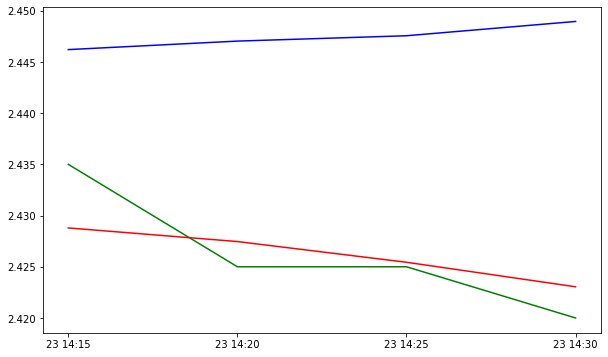

[*********************100%***********************]  1 of 1 completed
Take-Two Interactive Software, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Zynga Inc. - Class A Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Boxlight Corporation - Class A Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
WiMi Hologram Cloud Inc. - American Depositary Share is not a winner
[*********************100%***********************]  1 of 1 completed
Discovery, Inc. - Series C Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
iShares Short-Term Corporate Bond ETF is not a winner
[*********************100%***********************]  1 of 1 completed
Viavi Solutions Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- UMRX: No data foun

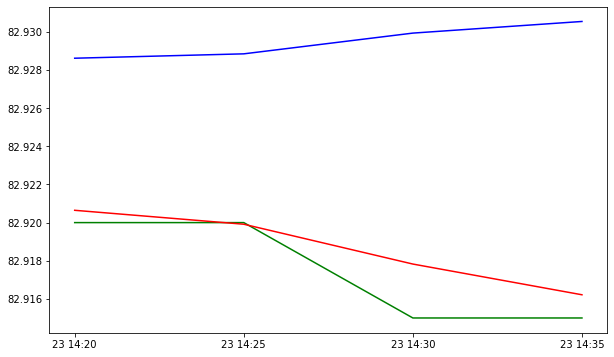

[*********************100%***********************]  1 of 1 completed
Trevena, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Adamis Pharmaceuticals Corporation - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
ProShares UltraPro QQQ is not a winner
[*********************100%***********************]  1 of 1 completed
Skyworks Solutions, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Avis Budget Group, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Tonix Pharmaceuticals Holding Corp. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Zscaler, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Moneygram International, Inc. - Common Stock is not a winner
[*************

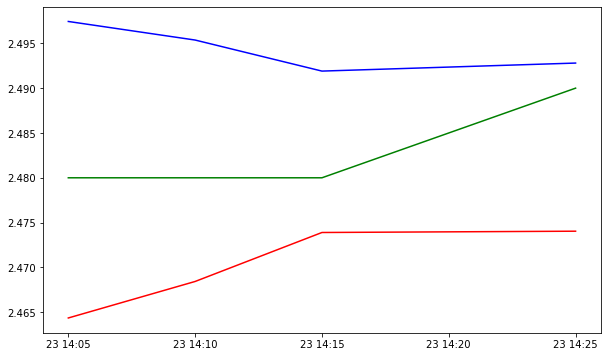

[*********************100%***********************]  1 of 1 completed
Midatech Pharma PLC - American Depositary Shares is not a winner
[*********************100%***********************]  1 of 1 completed
Sprouts Farmers Market, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
ON Semiconductor Corporation - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Clovis Oncology, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Sangamo Therapeutics, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Dave & Buster's Entertainment, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Huntington Bancshares Incorporated - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Roku, Inc. - Class 

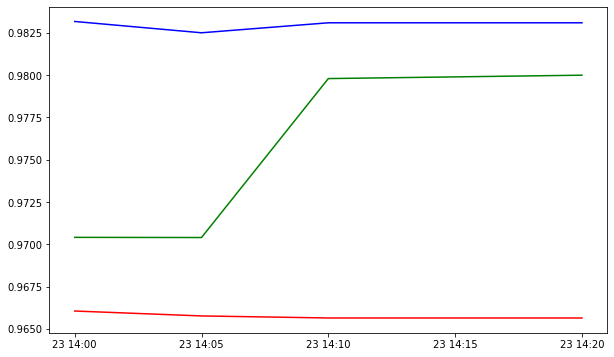

[*********************100%***********************]  1 of 1 completed
BELLUS Health Inc. - Common Shares is not a winner
[*********************100%***********************]  1 of 1 completed
Take-Two Interactive Software, Inc. - Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Zynga Inc. - Class A Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
Boxlight Corporation - Class A Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
WiMi Hologram Cloud Inc. - American Depositary Share is not a winner
[*********************100%***********************]  1 of 1 completed
Discovery, Inc. - Series C Common Stock is not a winner
[*********************100%***********************]  1 of 1 completed
iShares Short-Term Corporate Bond ETF is not a winner
[*********************100%***********************]  1 of 1 completed
Viavi Solutions Inc. - Common Stock is no

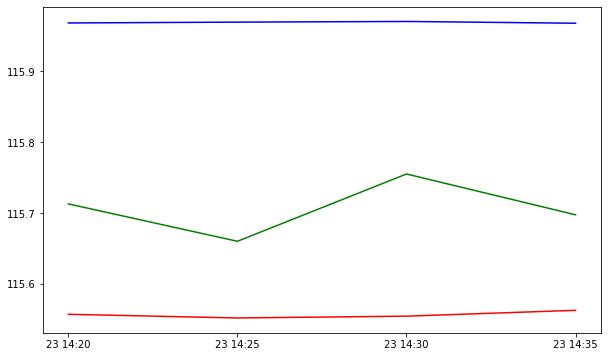

[*********************100%***********************]  1 of 1 completed
AMD is not a winner
[*********************100%***********************]  1 of 1 completed
T is not a winner
[*********************100%***********************]  1 of 1 completed
DAL is not a winner
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- J&J: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
INTC is not a winner
[*********************100%***********************]  1 of 1 completed
GE is not a winner
[*********************100%***********************]  1 of 1 completed
NIO is not a winner
[*********************100%***********************]  1 of 1 completed
JKS is not a winner


{'BLU', 'CJJD', 'IBM', 'VCSH', 'WATT'}

In [87]:
winners_ballinger = []  # a list that we will append with stocks that meet out conditions

#i = 0
for ticker, name in series_tickers.iteritems():
    #i = i +1
    try:
        my_stock = stock(ticker)
        my_stock.get_df()
        my_stock.macd()
        if my_stock.is_this_a_winner_ballinger(status_lower = ['normal','below_ballinger','below_ballinger']):
            print(name,'is a winner')
            my_stock.plot_df_ballinger()
            winners_ballinger.append(ticker)
        else:
            print(name,'is not a winner')
    except:
        continue
    #if i ==1:
        #break




winners_macd = []  # a list that we will append with stocks that meet out conditions

#i = 0
for ticker, name in series_tickers.iteritems():
    #i = i +1
    try:
        my_stock = stock(ticker)
        my_stock.get_df()
        my_stock.macd()
        if my_stock.is_this_a_winner_macd(colors = ['green','red','red']):
            print(name,'is a winner')
            my_stock.plot_df_ballinger()
            winners_macd.append(ticker)
        else:
            print(name,'is not a winner')
    except:
        continue
    #if i ==1:
        #break
        
set(winners_macd + winners_ballinger)

In [ ]:
set(winners_macd + winners_ballinger)

In [ ]:
list(set().union(winners_macd,winners_ballinger))

In [ ]:
list(set(winners_macd) & set(winners_ballinger))